In [1]:
import xarray as xr, numpy as np, pandas as pd
import pathlib, yaml
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
with open('../input.yml') as f:
    input_data = yaml.load(f, Loader=yaml.loader.SafeLoader)

In [3]:
study_area = input_data['study_area']

year_range_train = range(input_data['training_period']['start'], input_data['training_period']['end']+1)
year_range_test = range(input_data['testing_period']['start'], input_data['testing_period']['end']+1)

In [4]:
extreme_days_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'extreme_days')

with open(extreme_days_in_dir/'extreme_days_era.npy', 'rb') as f:
    extreme_days_era = np.load(f)

In [5]:
data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'input_data')
with xr.open_dataset(data_in_dir/'era5_rainfall.nc') as ds:
    era_p = ds.rainfall

with xr.open_dataset(data_in_dir/'era5_land_rainfall.nc') as ds:
    era_land_p = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'interp_sr')
with xr.open_dataset(data_in_dir/'era5_rainfall_sr.nc') as ds:
    era_p_interp = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'gp_sr')
with xr.open_dataset(data_in_dir/'era5_rainfall_sr.nc') as ds:
    era_p_gp = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'gan_sr')
with xr.open_dataset(data_in_dir/'era5_sr1.nc') as ds:
    era_p_gan = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'physics_linear_sr')
with xr.open_dataset(data_in_dir/'era5_sr1.nc') as ds:
    era_p_linear = ds.rainfall
    
data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'orographic_rainfall')
with xr.open_dataset(data_in_dir/'era5_sr1.nc') as ds:
    era_p_upslope = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'gan_gp_sr')
with xr.open_dataset(data_in_dir/'era5_sr1.nc') as ds:
    era_p_gan_gp = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'gan_gp_physics_sr')
with xr.open_dataset(data_in_dir/'era5_sr1.nc') as ds:
    era_p_gan_gp_upslope = ds.rainfall

data_in_dir = pathlib.Path(input_data['data_directories']['output']).joinpath(input_data['study_area'], 'gan_gp_physics2_sr')
with xr.open_dataset(data_in_dir/'era5_sr1.nc') as ds:
    era_p_gan_gp_linear = ds.rainfall

In [6]:
era_p_test = era_p.where(era_p.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_land_p_test = era_land_p.where(era_land_p.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_interp_test = era_p_interp.where(era_p_interp.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_gp_test = era_p_gp.where(era_p_gp.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_gan_test = era_p_gan.where(era_p_gan.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_linear_test = era_p_linear.where(era_p_linear.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_upslope_test = era_p_upslope.where(era_p_upslope.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_gan_gp_test = era_p_gan_gp.where(era_p_gan_gp.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_gan_gp_upslope_test = era_p_gan_gp_upslope.where(era_p_gan_gp_upslope.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)
era_p_gan_gp_linear_test = era_p_gan_gp_linear.where(era_p_gan_gp_linear.time.isin(extreme_days_era[np.isin(pd.DatetimeIndex(extreme_days_era).year, year_range_test)]), drop=True)

In [7]:
def entropy(X, nbin = 50):
    hist, bin_edges = np.histogram(X.ravel(), bins = nbin)
    px = hist / float(np.sum(hist))
    return np.sum(-px[px>0] * np.log(px[px>0]))

def mutual_info(X, Y, nbin = 50):
    hist2d, x_edges, y_edges = np.histogram2d(X.ravel(), Y.ravel(), bins = nbin)
    pxy = hist2d / float(np.sum(hist2d))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = np.outer(px, py)
    I_xy = np.sum(pxy[pxy>0] * np.log(pxy[pxy>0] / px_py[pxy > 0]))
    return I_xy

def normalised_mutual_info(X, Y, nbin = 50):
    return 2 * mutual_info(X, Y, nbin) / (entropy(X, nbin) + entropy(Y, nbin))

In [8]:
nbin = 50

spatial_mutual_info_interp = np.empty((era_p_interp_test.shape[1], era_p_interp_test.shape[2]))
for i in range(era_p_interp_test.shape[1]):
    for j in range(era_p_interp_test.shape[2]):
        spatial_mutual_info_interp [i, j] = normalised_mutual_info(era_p_interp_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_gp = np.empty((era_p_gp_test.shape[1], era_p_gp_test.shape[2]))
for i in range(era_p_gp_test.shape[1]):
    for j in range(era_p_gp_test.shape[2]):
        spatial_mutual_info_gp [i, j] = normalised_mutual_info(era_p_gp_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_gan = np.empty((era_p_gan_test.shape[1], era_p_gan_test.shape[2]))
for i in range(era_p_gan_test.shape[1]):
    for j in range(era_p_gan_test.shape[2]):
        spatial_mutual_info_gan [i, j] = normalised_mutual_info(era_p_gan_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_linear = np.empty((era_p_linear_test.shape[1], era_p_linear_test.shape[2]))
for i in range(era_p_linear_test.shape[1]):
    for j in range(era_p_linear_test.shape[2]):
        spatial_mutual_info_linear [i, j] = normalised_mutual_info(era_p_linear_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_upslope = np.empty((era_p_upslope_test.shape[1], era_p_upslope_test.shape[2]))
for i in range(era_p_upslope_test.shape[1]):
    for j in range(era_p_upslope_test.shape[2]):
        spatial_mutual_info_upslope [i, j] = normalised_mutual_info(era_p_upslope_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_gan_gp = np.empty((era_p_gan_gp_test.shape[1], era_p_gan_gp_test.shape[2]))
for i in range(era_p_gan_gp_test.shape[1]):
    for j in range(era_p_gan_gp_test.shape[2]):
        spatial_mutual_info_gan_gp [i, j] = normalised_mutual_info(era_p_gan_gp_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_gan_gp_upslope = np.empty((era_p_gan_gp_upslope_test.shape[1], era_p_gan_gp_upslope_test.shape[2]))
for i in range(era_p_gan_gp_upslope_test.shape[1]):
    for j in range(era_p_gan_gp_upslope_test.shape[2]):
        spatial_mutual_info_gan_gp_upslope [i, j] = normalised_mutual_info(era_p_gan_gp_upslope_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)

spatial_mutual_info_gan_gp_linear = np.empty((era_p_gan_gp_linear_test.shape[1], era_p_gan_gp_linear_test.shape[2]))
for i in range(era_p_gan_gp_linear_test.shape[1]):
    for j in range(era_p_gan_gp_linear_test.shape[2]):
        spatial_mutual_info_gan_gp_linear [i, j] = normalised_mutual_info(era_p_gan_gp_linear_test.values[:,i,j], era_land_p_test.values[:,i,j], nbin)


In [ ]:
fig = plt.figure(figsize=(8,6))
plt.boxplot([spatial_mutual_info_interp.ravel(), spatial_mutual_info_linear.ravel(), spatial_mutual_info_upslope.ravel(), spatial_mutual_info_gp.ravel(), spatial_mutual_info_gan.ravel(), spatial_mutual_info_gan_gp.ravel(), spatial_mutual_info_gan_gp_upslope.ravel(), spatial_mutual_info_gan_gp_linear.ravel()], showfliers=False);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['Bicubic\nInterp.', 'Physics\n(Spectral)', 'Physics\n(Upslope)', 'GP', 'GAN', 'GP+GAN', 'GP+GAN\n+Upslope', 'GP+GAN\n+Spectral']);
plt.ylabel('Normalized Mutual Information');

In [10]:
def ecdf(x):
    xs = np.sort(x.ravel())
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

In [11]:
def ecdf_find_nearest(array, value):
    array = array.ravel()
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or np.abs(value - array[idx-1]) < np.abs(value - array[idx])):
        return idx-1
    else:
        return idx

In [12]:
def compute_bias_variance(sr, hr):
    b = np.empty(hr.shape[0])
    v = np.empty(hr.shape[0])

    for j in range(hr.shape[0]):
        HR = hr[j, 0, ...]
        SR = sr[j, 0, ...]

        ECDF_sr, y_sr = ecdf(SR)
        ECDF_hr, y_hr = ecdf(HR)

        b[j] = np.mean(np.abs(ECDF_hr - ECDF_sr))

        N = len(HR.ravel())
        VAR = np.empty(N)
        for k in range(N):
            idx = ecdf_find_nearest(ECDF_sr, ECDF_hr[k])
            VAR[k] = np.abs(y_hr[k] - y_sr[idx])

        v[j] = np.max(VAR)

    return b, v

In [13]:
bias_interp, variance_interp = compute_bias_variance(era_p_interp_test.values, era_land_p_test.values)
bias_gp, variance_gp = compute_bias_variance(era_p_gp_test.values, era_land_p_test.values)
bias_gan, variance_gan = compute_bias_variance(era_p_gan_test.values, era_land_p_test.values)
bias_linear, variance_linear = compute_bias_variance(era_p_linear_test.values, era_land_p_test.values)
bias_upslope, variance_upslope = compute_bias_variance(era_p_upslope_test.values, era_land_p_test.values)
bias_gan_gp, variance_gan_gp = compute_bias_variance(era_p_gan_gp_test.values, era_land_p_test.values)
bias_gan_gp_upslope, variance_gan_gp_upslope = compute_bias_variance(era_p_gan_gp_upslope_test.values, era_land_p_test.values)
bias_gan_gp_linear, variance_gan_gp_linear = compute_bias_variance(era_p_gan_gp_linear_test.values, era_land_p_test.values)

In [ ]:
plt.scatter(np.mean(bias_interp), np.mean(variance_interp), c='b', s=40, edgecolor='none', label='Interp.')
plt.scatter(np.mean(bias_gp), np.mean(variance_gp), c='g', s=40, edgecolor='none', label='CGP')
plt.scatter(np.mean(bias_gan), np.mean(variance_gan), c='r', s=40, edgecolor='none', label='GAN')
plt.scatter(np.mean(bias_linear), np.mean(variance_linear), c='#b8922a', s=40, edgecolor='none', label='Physics (Spectral)')
plt.scatter(np.mean(bias_upslope), np.mean(variance_upslope), c='#47c977', s=40, edgecolor='none', label='Physics (Upslope)')
plt.scatter(np.mean(bias_gan_gp), np.mean(variance_gan_gp), c='magenta', s=40, edgecolor='none', label='CGP+GAN')
plt.scatter(np.mean(bias_gan_gp_upslope), np.mean(variance_gan_gp_upslope), c='k', s=40, edgecolor='none', label='CGP+GAN\n+Upslope')
plt.scatter(np.mean(bias_gan_gp_linear), np.mean(variance_gan_gp_linear), c='orange', s=40, edgecolor='none', label='CGP+GAN\n+Physics (Spectral)')
plt.title('Bias vs Kolmogorov-Smirnov Statistic')
plt.xlabel('Bias [mm]')
plt.ylabel('KS Stat.')
plt.legend(loc='upper left')

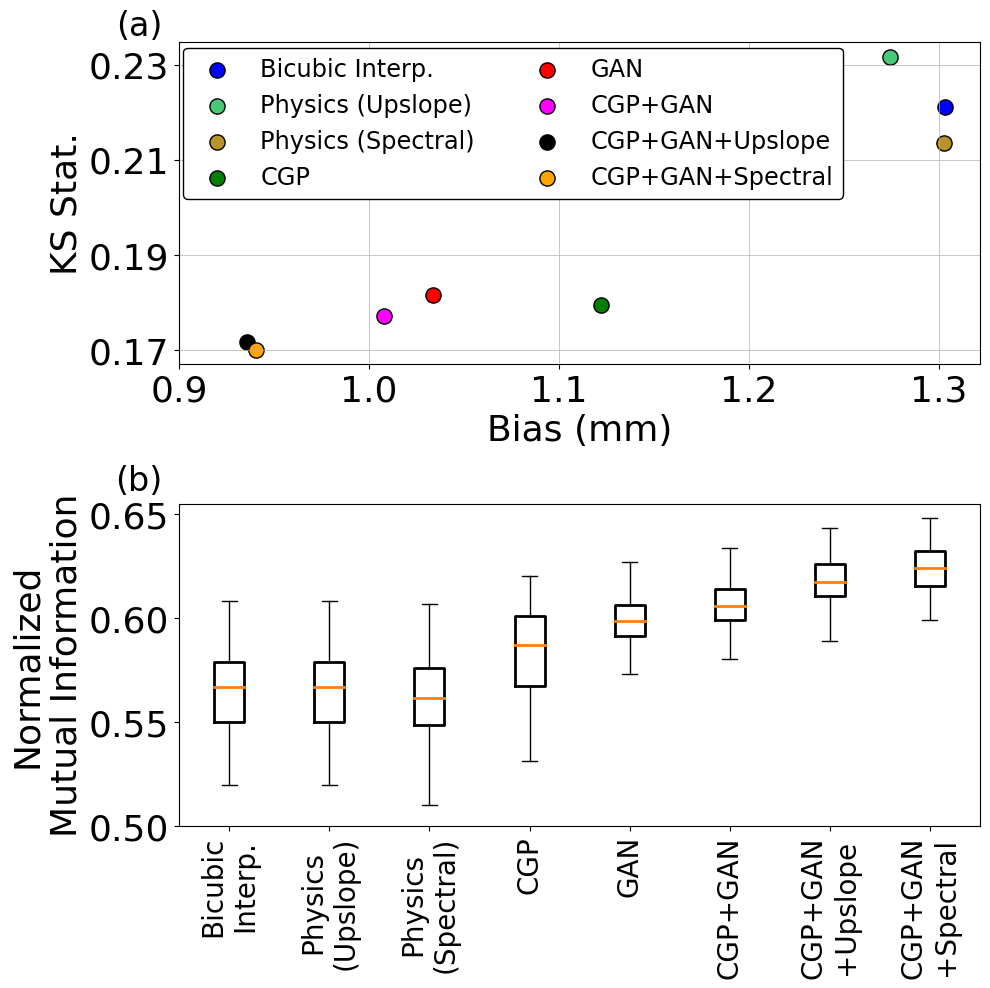

In [15]:
fig = plt.figure(figsize=(10,10))
fontsize = 26

ax = fig.add_subplot(211)
plt.scatter(np.mean(bias_interp), np.mean(variance_interp), c='b', s=120, edgecolor='black', label='Interp.')
plt.scatter(np.mean(bias_gp), np.mean(variance_gp), c='g', s=120, edgecolor='black', label='CGP')
plt.scatter(np.mean(bias_gan), np.mean(variance_gan), c='r', s=120, edgecolor='black', label='GAN')
plt.scatter(np.mean(bias_linear), np.mean(variance_linear), c='#b8922a', s=120, edgecolor='black', label='Physics (Spectral)')
plt.scatter(np.mean(bias_upslope), np.mean(variance_upslope), c='#47c977', s=120, edgecolor='black', label='Physics (Upslope)')
plt.scatter(np.mean(bias_gan_gp), np.mean(variance_gan_gp), c='magenta', s=120, edgecolor='black', label='CGP+GAN')
plt.scatter(np.mean(bias_gan_gp_upslope), np.mean(variance_gan_gp_upslope), c='k', s=120, edgecolor='black', label='CGP+GAN\n+Upslope')
plt.scatter(np.mean(bias_gan_gp_linear), np.mean(variance_gan_gp_linear), c='orange', s=120, edgecolor='black', label='CGP+GAN\n+Physics (Spectral)')
plt.xlabel("Bias (mm)", fontsize=fontsize)
plt.ylabel("KS Stat.", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(linestyle='-', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(-0.01,1.02), ncol=2, fontsize=fontsize/1.5, framealpha=1, edgecolor="black")
ax.text(-0.05, 1.05, '(a)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.set_yticks([0.17, 0.19, 0.21, 0.23])
ax.set_xticks([0.9, 1.0, 1.1, 1.2, 1.3])

ax = fig.add_subplot(212)
plt.boxplot([spatial_mutual_info_interp.ravel(), spatial_mutual_info_upslope.ravel(), spatial_mutual_info_linear.ravel(), spatial_mutual_info_gp.ravel(), spatial_mutual_info_gan.ravel(), spatial_mutual_info_gan_gp.ravel(), spatial_mutual_info_gan_gp_upslope.ravel(), spatial_mutual_info_gan_gp_linear.ravel()], showfliers=False, medianprops=dict(linewidth=2), boxprops=dict(linewidth=2), widths=0.3);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['Bicubic\nInterp.', 'Physics\n(Upslope)', 'Physics\n(Spectral)', 'CGP', 'GAN', 'CGP+GAN', 'CGP+GAN\n+Upslope', 'CGP+GAN\n+Spectral'], fontsize=fontsize/1.3, rotation = 90);
plt.yticks([0.5, 0.55, 0.6, 0.65], fontsize=fontsize)
plt.ylabel('Normalized\nMutual Information', fontsize=fontsize);
ax.text(-0.05, 1.07, '(b)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.tight_layout()
plt.show()

In [16]:
mi = np.array([spatial_mutual_info_interp.ravel(), spatial_mutual_info_upslope.ravel(), spatial_mutual_info_linear.ravel(), spatial_mutual_info_gp.ravel(), spatial_mutual_info_gan.ravel(), spatial_mutual_info_gan_gp.ravel(), spatial_mutual_info_gan_gp_upslope.ravel(), spatial_mutual_info_gan_gp_linear.ravel()])
ba = np.array([bias_interp, bias_upslope, bias_linear, bias_gp, bias_gan, bias_gan_gp, bias_gan_gp_upslope, bias_gan_gp_linear])
va = np.array([variance_interp, variance_upslope, variance_linear, variance_gp, variance_gan, variance_gan_gp, variance_gan_gp_upslope, variance_gan_gp_linear])
mi_tp = np.array([[ttest_ind(a, b)[1]<0.05 for a in mi] for b in mi])
ba_tp = np.array([[ttest_ind(a, b)[1]<0.05 for a in ba] for b in ba])
va_tp = np.array([[ttest_ind(a, b)[1]<0.05 for a in va] for b in va])

Text(-0.1, 1.05, '(c)')

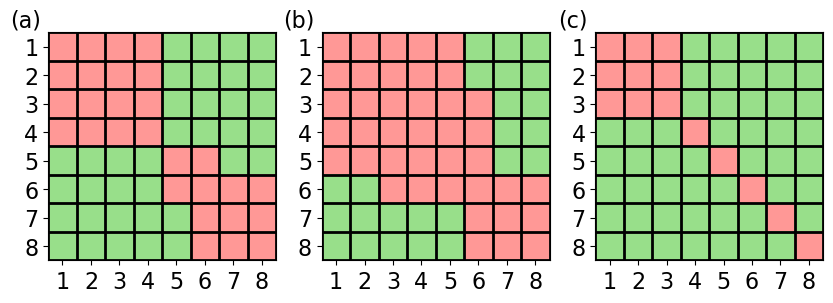

In [17]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(131)
plt.imshow(ba_tp, cmap='tab20_r', vmin=-5.5, vmax=3.5)
# Major ticks
ax.set_xticks(np.arange(0, 8, 1))
ax.set_yticks(np.arange(0, 8, 1))
# Labels for major ticks
ax.set_xticklabels(np.arange(1, 9, 1), fontsize=16)
ax.set_yticklabels(np.arange(1, 9, 1), fontsize=16)
# Minor ticks
ax.set_xticks(np.arange(-0.5, 8.5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 8.5, 1), minor=True)
# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)
ax.text(-0.1, 1.05, '(a)', fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(132)
plt.imshow(va_tp, cmap='tab20_r', vmin=-5.5, vmax=3.5)
# Major ticks
ax.set_xticks(np.arange(0, 8, 1))
ax.set_yticks(np.arange(0, 8, 1))
# Labels for major ticks
ax.set_xticklabels(np.arange(1, 9, 1), fontsize=16)
ax.set_yticklabels(np.arange(1, 9, 1), fontsize=16)
# Minor ticks
ax.set_xticks(np.arange(-0.5, 8.5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 8.5, 1), minor=True)
# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)
ax.text(-0.1, 1.05, '(b)', fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(133)
plt.imshow(mi_tp, cmap='tab20_r', vmin=-5.5, vmax=3.5)
# Major ticks
ax.set_xticks(np.arange(0, 8, 1))
ax.set_yticks(np.arange(0, 8, 1))
# Labels for major ticks
ax.set_xticklabels(np.arange(1, 9, 1), fontsize=16)
ax.set_yticklabels(np.arange(1, 9, 1), fontsize=16)
# Minor ticks
ax.set_xticks(np.arange(-0.5, 8.5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 8.5, 1), minor=True)
# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)
ax.text(-0.1, 1.05, '(c)', fontsize=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


In [ ]:
import matplotlib.ticker as mticker, cartopy.crs as ccrs, cartopy.feature as cfeature, cartopy.mpl.ticker as cticker
lon_bound = (-88.25, -87.25)
lat_bound = (41.4, 42.4)
lat_rain_lr = np.arange(lat_bound[1]-0.125, lat_bound[0], -0.25)
lon_rain_lr = np.arange(lon_bound[0]+0.125, lon_bound[1], 0.25)
lat_rain_hr = np.arange(lat_bound[1]-0.05, lat_bound[0], -0.1)
lon_rain_hr = np.arange(lon_bound[0]+0.05, lon_bound[1], 0.1)

n = np.random.randint(0, np.shape(era_p)[0])
print(n)

ec = "black"
vmax = max(np.max(era_p[n,:,:]), np.max(era_p_gan_gp_upslope[n,:,:]), np.max(era_land_p[n,:,:]))
vmin = 0

fig, ax = plt.subplots(nrows = 3, ncols = 4, subplot_kw = {'projection': ccrs.PlateCarree()}, figsize = (52, 60))
ax = ax.flatten()

ax[0].set_extent([np.max(lon_rain_lr)+0.125, np.min(lon_rain_lr)-0.125, np.min(lat_rain_lr)-0.125, np.max(lat_rain_lr)+0.125], ccrs.PlateCarree())
pc0 = ax[0].pcolormesh(lon_rain_lr, lat_rain_lr, era_p[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[0].set_title("Low Resolution\n(ERA5)\n(0.25°×0.25°)")
ax[0].text(-0.2, 1.1, '(a)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

ax[2].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[2].pcolormesh(lon_rain_hr, lat_rain_hr, era_land_p[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[2].set_title("High Resolution Reference\n(ERA5-Land)\n(0.1°×0.1°)")
ax[2].text(-0.2, 1.1, '(b)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)

ax[4].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[4].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_interp[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[4].set_title("Super-Resolution\nBicubic Interp.\n(0.1°×0.1°)")
ax[4].text(0, 1.1, '(c)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[4].transAxes)

ax[5].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[5].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_upslope[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[5].set_title("Super-Resolution\nPhysics (Upslope)\n(0.1°×0.1°)")
ax[5].text(0, 1.05, '(d)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[5].transAxes)

ax[6].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[6].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_linear[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[6].set_title("Super-Resolution\nPhysics (Spectral)\n(0.1°×0.1°)")
ax[6].text(0, 1.1, '(e)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[6].transAxes)

ax[7].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[7].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_gp[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[7].set_title("Super-Resolution\nCGP (0.1°×0.1°)")
ax[7].text(-0.1, 1.1, '(f)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[7].transAxes)

ax[8].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[8].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_gan[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[8].set_title("Super-Resolution\nGAN (0.1°×0.1°)")
ax[8].text(-0.1, 1.1, '(g)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[8].transAxes)

ax[9].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[9].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_gan_gp[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[9].set_title("Super-Resolution\nCGP+GAN\n(0.1°×0.1°)")
ax[9].text(0, 1.1, '(h)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[9].transAxes)

ax[10].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[10].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_gan_gp_upslope[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[10].set_title("Super-Resolution\nCGP+GAN+Upslope\n(0.1°×0.1°)")
ax[10].text(0, 1.05, '(i)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[10].transAxes)

ax[11].set_extent([np.max(lon_rain_hr)+0.05, np.min(lon_rain_hr)-0.05, np.min(lat_rain_hr)-0.05, np.max(lat_rain_hr)+0.05], ccrs.PlateCarree())
pc3 = ax[11].pcolormesh(lon_rain_hr, lat_rain_hr, era_p_gan_gp_linear[n,:,:], cmap=plt.get_cmap("gist_earth_r"), shading="auto", vmin=vmin, vmax=vmax)
ax[11].set_title("Super-Resolution\nCGP+GAN+Spectral\n(0.1°×0.1°)")
ax[11].text(0, 1.05, '(j)', fontsize=80, horizontalalignment='center', verticalalignment='center', transform=ax[11].transAxes)

for a in ax:
    a.add_feature(cfeature.STATES, linewidth=4, edgecolor=ec)
    a.set_xticks([-88, -87.5], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.set_yticks([41.75, 42.25], crs=ccrs.PlateCarree())
    a.set_yticklabels([41.75, 42.25], rotation=90, va="center")
    lat_formatter = cticker.LatitudeFormatter()
    a.yaxis.set_major_formatter(lat_formatter)
    a.tick_params(axis="y", direction='inout', length=14, labelsize=60)
    a.tick_params(axis="x", direction='inout', length=14, labelsize=60)

cbar_ax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
cbar=fig.colorbar(pc0, cax=cbar_ax)
cbar.set_label('mm', rotation=270, labelpad=50)

plt.rc('font', size=60)
plt.rcParams['axes.titley'] = 1.0
plt.rcParams['axes.titlepad'] = 15

ax[1].set_visible(False)
ax[3].set_visible(False)